<a href="https://colab.research.google.com/github/Erech2020/DeepLearning/blob/master/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install keras
#import keras

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%tensorflow_version 1.x
%cd /content/drive/My Drive/ColabNotebooks
#%ls
%pwd

TensorFlow 1.x selected.
/content/drive/My Drive/ColabNotebooks


'/content/drive/My Drive/ColabNotebooks'

In [0]:
#!unzip validacion.zip 


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import keras
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam, adam
from keras.models import Sequential, load_model, save_model
from keras.layers.core import Dropout, Flatten, Dense, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras import backend as k
from keras.applications import densenet, resnet50, vgg16
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [4]:
np.random.seed(2)
k.clear_session()
ruta_data_entrenamiento = './data/entrenamiento'
ruta_data_validacion = './data/validacion'

epocas=15
longitud, altura = 224, 224 #96,96 #128,128
batch_size = 12  #32#128 #32 numero mínimo de imágenes de cada clase
pasos = 1000
validation_steps = 200#200
nclases = 242#287
lr = 0.01#0.0004

In [5]:
entrenamiento_datagen = ImageDataGenerator(rescale = 1./ 255)
                                           #horizontal_flip=True,

validacion_datagen = ImageDataGenerator(rescale = 1. / 255)

entrenamiento_generador = entrenamiento_datagen.flow_from_directory(
    ruta_data_entrenamiento,       #ruta de la carpeta de imagenes entrenamiento
    target_size=(altura, longitud),
    color_mode='rgb',#'grayscale'
    batch_size=batch_size,    #número de imágenes que se generarán desde el generador por lote
    class_mode='categorical', #para mas de dos clases
    shuffle = True, #era True 
    seed = 42)

validacion_generador = validacion_datagen.flow_from_directory(
    ruta_data_validacion,     #ruta de la carpeta de imagenes validacion
    target_size=(altura, longitud),
    color_mode='rgb',#'grayscale'
    batch_size=1,#batch_size,
    class_mode='categorical',  #None, para devolver solo las imágenes
    shuffle = False,           #se requiere mostrar en orden las imagenes de salida
    seed = 42) 


Found 19700 images belonging to 242 classes.
Found 8296 images belonging to 242 classes.


<h1> Implementando el Modelo </h1>

In [6]:
from keras.applications import DenseNet121
from keras.layers import GlobalAveragePooling2D
from keras.models import Model

def VGG16_(): #Arquitectura original a excepcion del numero de clases
  base_model = vgg16.VGG16(include_top=False, weights='imagenet',
                           input_shape=(longitud, altura, 3), classes=nclases)
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(4096, activation='relu')(x)
  x = Dense(4096, activation='relu')(x)
  predictions = Dense(nclases, activation='softmax') (x) # era'softmax' 'sigmoid')(x)

  model = Model(inputs=base_model.input, outputs=predictions)
  return model
"""
modelo =vgg16.VGG16(include_top=False, weights='imagenet',
        input_shape=(longitud, altura, 3), classes=nclases)
"""

"\nmodelo =vgg16.VGG16(include_top=False, weights='imagenet',\n        input_shape=(longitud, altura, 3), classes=nclases)\n"

In [7]:
modelo = VGG16_()
modelo.summary()










Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)  

## Compilacion

In [8]:
sgd  = SGD(lr=0.01)
adam  = Adam(lr=0.001)
modelo.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy','mse'])
#keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

<h1> Entrenamiento </h1>

In [10]:
earlystopper = EarlyStopping(patience=3, verbose=1) #patience era 5 bajamos a 3 para ver que si en tres no mejora me quedo con el último
checkpointer = ModelCheckpoint('./checkpoint0.h5', verbose=1, save_best_only=True)

modeloEntrenado = modelo.fit_generator(
    entrenamiento_generador,#Entrenamiento
    steps_per_epoch=pasos,#1000
    epochs=epocas,#epocas,
    validation_data=validacion_generador,#validation_steps=validation_steps,#300
    callbacks=[earlystopper, checkpointer],shuffle=True,workers=200)

print("guardando el modelo")
target_dir = './modelo0/'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
modelo.save('./modelo0/modelo.h5')
modelo.save_weights('./modelo0/pesos.h5')

dic=validacion_generador.class_indices
etiquetas=list(dic.keys())
etiquetas_f='\n'.join(etiquetas)
f = open ('./modelo0/labels.txt','w')
f.write(etiquetas_f)
f.close()

#Histórico
import pickle

with open('./modelo0/mod_compi_history.txt', 'wb') as file_pi:  
  pickle.dump(modeloEntrenado.history, file_pi)

Epoch 1/15
1000/1000 [==============================] - 608s 608ms/step - loss: 2.2559 - acc: 0.4492 - mean_squared_error: 0.0029 - val_loss: 1.5587 - val_acc: 0.6063 - val_mean_squared_error: 0.0022

Epoch 00001: val_loss improved from inf to 1.55868, saving model to ./checkpoint0.h5
Epoch 2/15
1000/1000 [==============================] - 608s 608ms/step - loss: 1.0934 - acc: 0.7097 - mean_squared_error: 0.0017 - val_loss: 1.0069 - val_acc: 0.7236 - val_mean_squared_error: 0.0016

Epoch 00002: val_loss improved from 1.55868 to 1.00692, saving model to ./checkpoint0.h5
Epoch 3/15
1000/1000 [==============================] - 608s 608ms/step - loss: 0.5555 - acc: 0.8468 - mean_squared_error: 9.2763e-04 - val_loss: 0.3925 - val_acc: 0.8928 - val_mean_squared_error: 6.6384e-04

Epoch 00003: val_loss improved from 1.00692 to 0.39247, saving model to ./checkpoint0.h5
Epoch 4/15
1000/1000 [==============================] - 608s 608ms/step - loss: 0.3127 - acc: 0.9151 - mean_squared_error: 5.2

In [11]:
evaluacionDelModelo=modelo.evaluate_generator(validacion_generador, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False)
print(evaluacionDelModelo)#Loss, Acc, Mean_scuared_error

[0.12048231497318813, 0.9685390549662488, 0.0001922566433280272]


<h2>Predicción del modelo</h2>

In [12]:
pred = modelo.predict_generator(validacion_generador, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1)
predicted = np.argmax(pred, axis=1)

8296/8296 [==============================] - 198s 24ms/step


In [0]:
def nombre_corto (nombres):
    nombres_cortos=list()
    for nombre in nombres:
        cad=""
        vacio=0
        for i in nombre[4:]:
            if(i!="_" or i!=" " and vacio<=2):
                
                cad=cad+i
                if(vacio==2):
                    cad=cad+"."
                    break
            if(i=="_" or i==" "):
                vacio=vacio+1

                
        nombres_cortos.append(cad)
    return nombres_cortos



In [0]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn


In [15]:
print('Classification Report')

target_names = etiquetas #validacion_generador.class_indices.keys()
target_names_reducido = nombre_corto(target_names) 
print(classification_report(validacion_generador.classes, predicted, target_names=target_names_reducido))

Classification Report
                        precision    recall  f1-score   support

    Abelardo_Zapata_T.       0.94      1.00      0.97        30
Alejandro_Francisco_T.       1.00      1.00      1.00        32
      Alexis_Pillco_C.       1.00      0.97      0.98        58
      Aquilina_Jara_P.       1.00      1.00      1.00        13
 Arquitecto_Huarton_V.       1.00      1.00      1.00        16
   Aurelio_Antezana_M.       1.00      1.00      1.00        40
  Benedicta_Guillen_T.       0.96      1.00      0.98        26
   Benigno_Ccoragua_M.       1.00      0.83      0.91        30
      Benigno_Utani_M.       1.00      1.00      1.00        34
     Betina_Lourdes_V.       1.00      1.00      1.00        24
       Betty_Yovana_B.       1.00      0.93      0.96        73
      Branco_Ccallo_S.       1.00      0.97      0.98        33
 Braulio_Batallanos_C.       1.00      0.90      0.95        31
         Carel_Puga_O.       1.00      0.96      0.98        46
     Carlos_Fuent

In [0]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

x=validacion_generador.classes                         
cm = confusion_matrix(x, predicted)

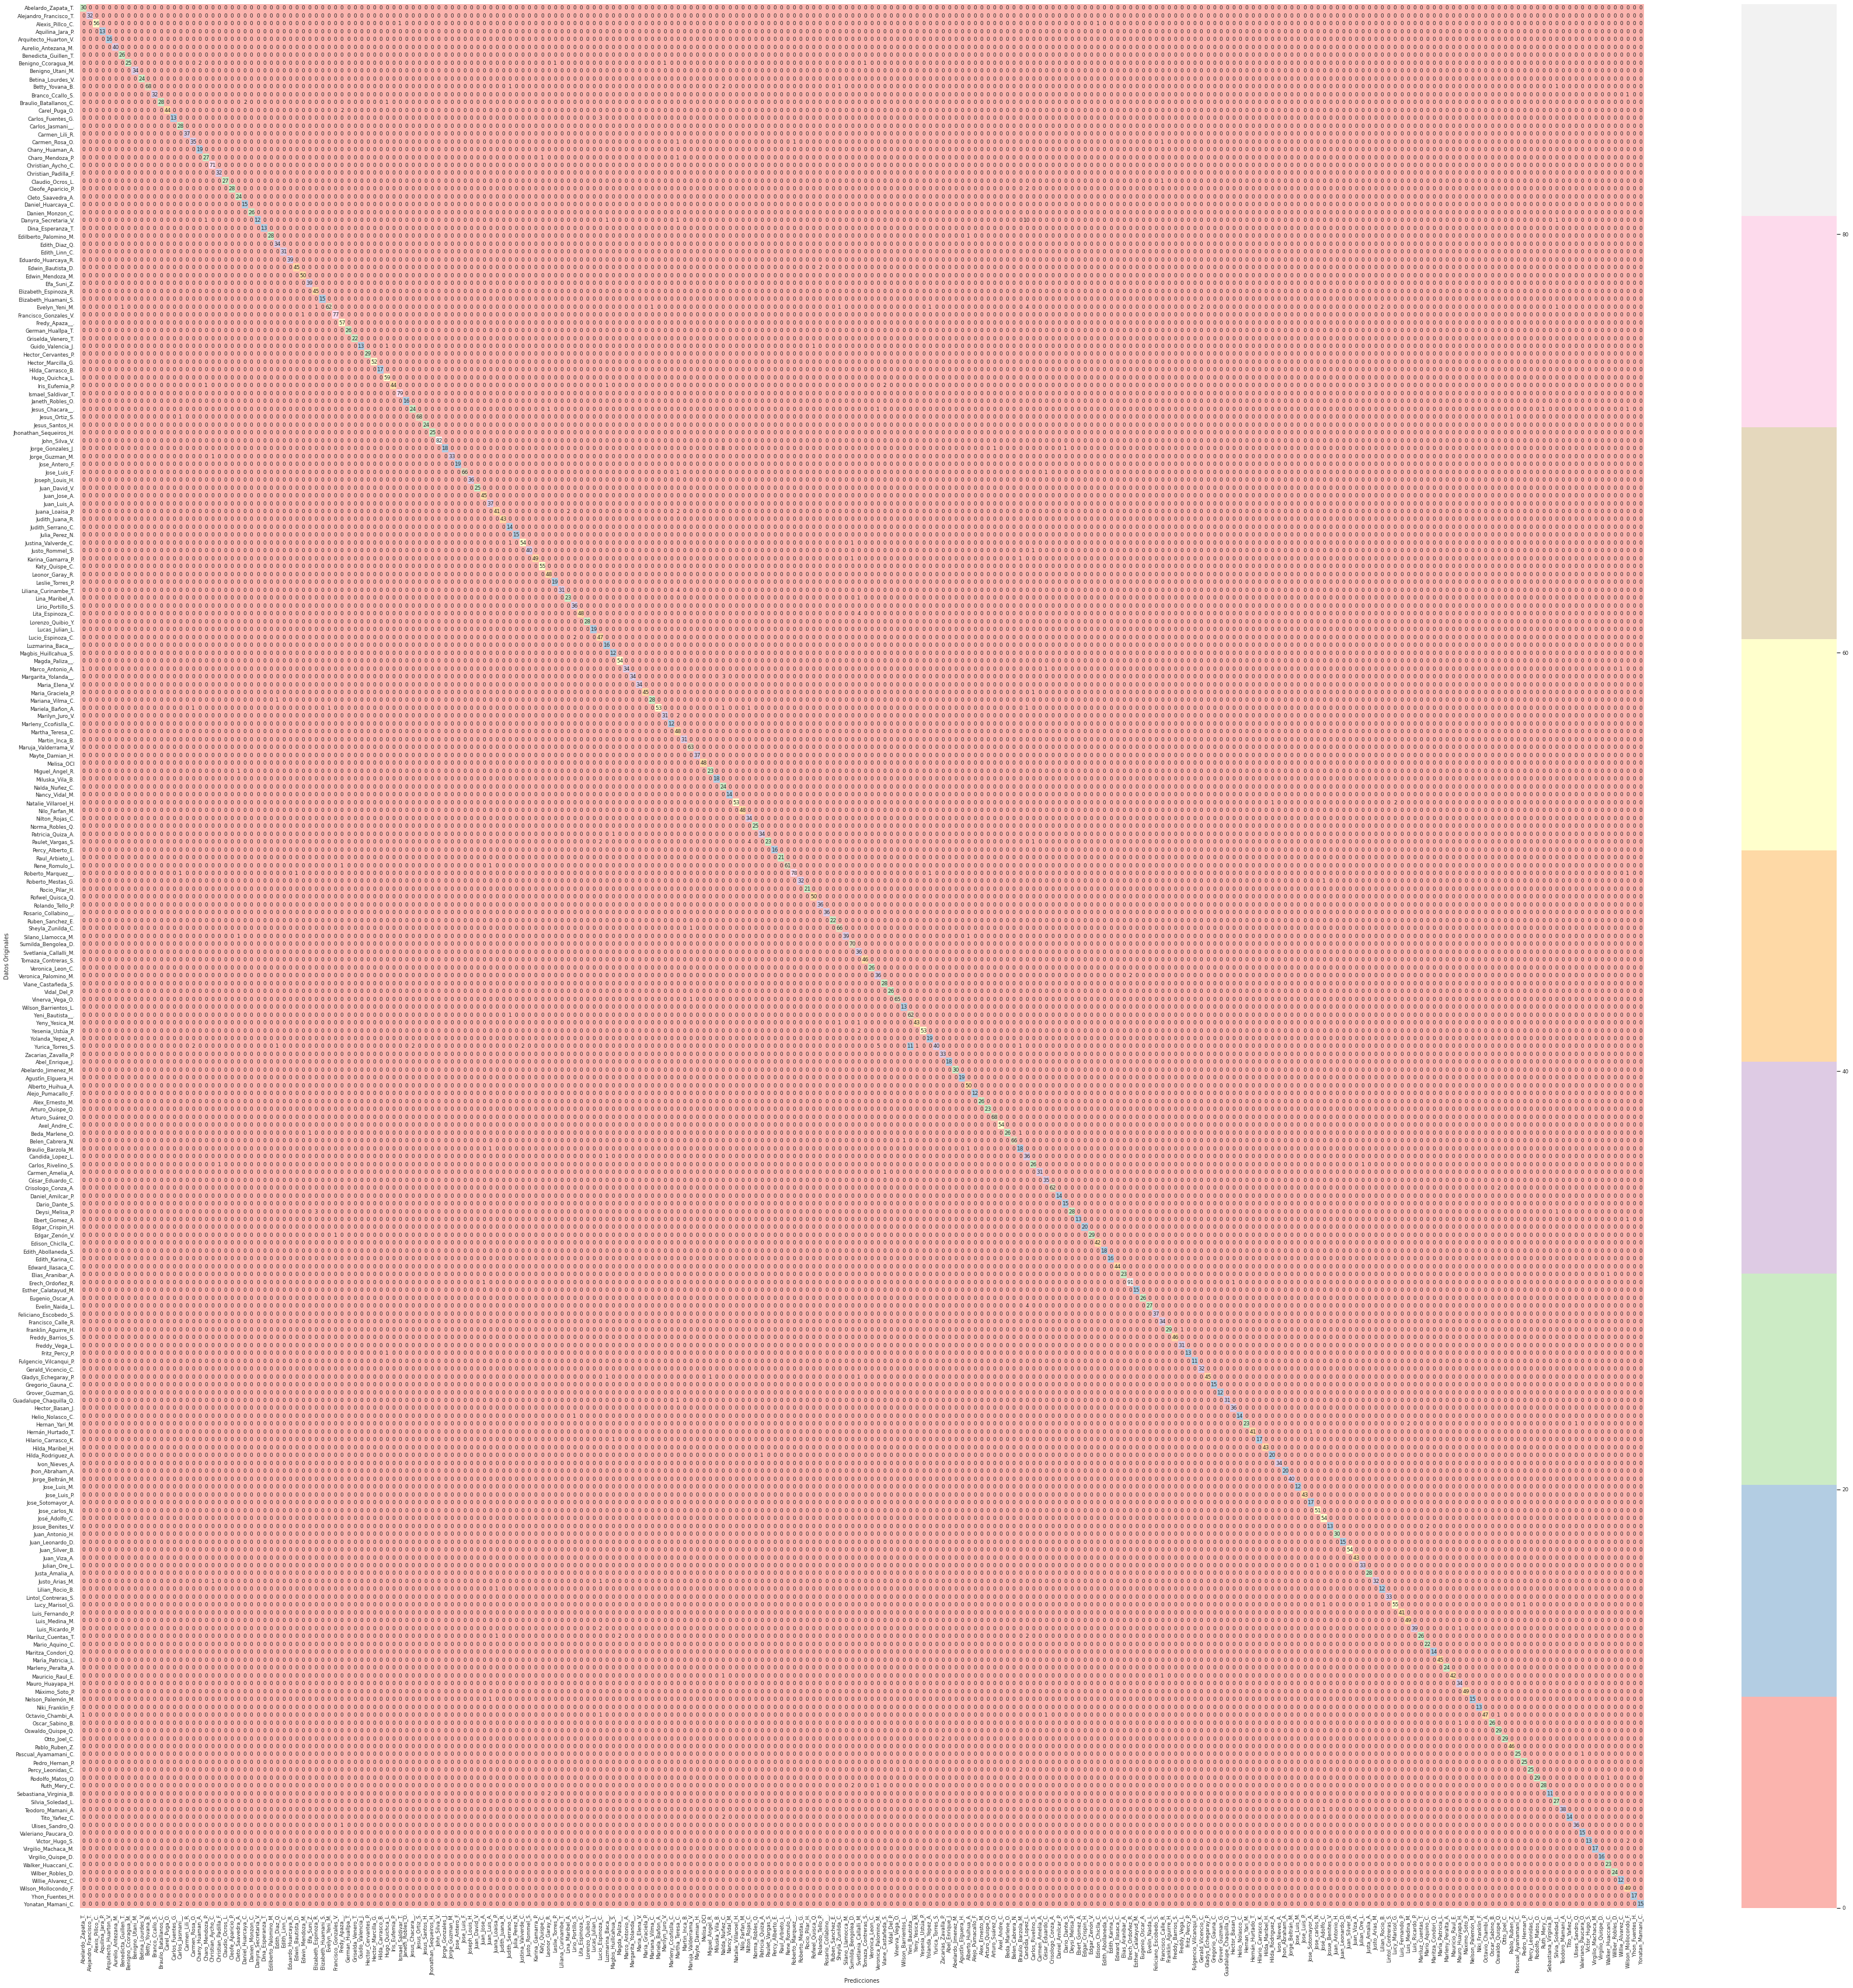

In [17]:
df_cm = pd.DataFrame(cm,target_names_reducido, target_names_reducido) 
plt.figure(figsize = (60,60))  #tamaño de la imagen longitud y altura
sn.set(font_scale=0.8) # tamaño de las clases
grafica=sn.heatmap(df_cm,cmap='Pastel1',annot=True, annot_kws={"size": 9})
grafica.set(xlabel='Predicciones',ylabel='Datos Originales')
plt.show()

In [0]:
#guardar la matriz de confusion
df_cm.to_csv('./modelo0/matrizConfusion.csv')# guardar la matriz de conf

In [19]:
import pickle
import numpy as np 
import csv
reporte_clasif=classification_report(validacion_generador.classes, predicted, target_names=target_names_reducido,output_dict=True)
#reporte = pd.DataFrame(reporte_clasif,range(242),range(1))#,columns=['Names', 'Precision', 'Recall','F1-Score','Suport']) 
print(reporte_clasif)


{'Abelardo_Zapata_T.': {'precision': 0.9375, 'recall': 1.0, 'f1-score': 0.967741935483871, 'support': 30}, 'Alejandro_Francisco_T.': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 32}, 'Alexis_Pillco_C.': {'precision': 1.0, 'recall': 0.9655172413793104, 'f1-score': 0.9824561403508771, 'support': 58}, 'Aquilina_Jara_P.': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 13}, 'Arquitecto_Huarton_V.': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 16}, 'Aurelio_Antezana_M.': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 40}, 'Benedicta_Guillen_T.': {'precision': 0.9629629629629629, 'recall': 1.0, 'f1-score': 0.9811320754716981, 'support': 26}, 'Benigno_Ccoragua_M.': {'precision': 1.0, 'recall': 0.8333333333333334, 'f1-score': 0.9090909090909091, 'support': 30}, 'Benigno_Utani_M.': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, 'Betina_Lourdes_V.': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 24}

In [0]:
import pandas as pd

dataform=pd.DataFrame.from_dict(data=reporte_clasif).transpose()
dataform.to_csv('./modelo0/reporteF.csv', header=reporte_clasif.keys()) 

Predecir


In [22]:
p=[0.0, 0.3, 0.9, 0., 0.0]
#p=[0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

c=['ma','ve','se','el','tu']

def predicciones_nombres(lista_predicciones,lista_etiquetas,valor_minimo=0.3):
    nombre_01=""
    nombre_02=""
    da01=0.0
    da02=0.0
    for i,data in enumerate(lista_predicciones):
        if(data>=valor_minimo):
            if(data>=da01):#intercambio de variables
                aux01=da01
                da01=data
                aux02=nombre_01
                nombre_01=lista_etiquetas[i] 
                da02=aux01
                nombre_02=aux02
    return (nombre_01,da01),(nombre_02,da02)
a1,a2 = predicciones_nombres(p,c)
print(a1)
print(a2)

('se', 0.9)
('ve', 0.3)


La suma de la prediccion es:  0.9999999670681063
[0.003, 0.001, 0.002, 0.0, 0.006, 0.044, 0.01, 0.002, 0.001, 0.049, 0.001, 0.001, 0.001, 0.001, 0.0, 0.001, 0.001, 0.0, 0.245, 0.0, 0.002, 0.001, 0.011, 0.001, 0.0, 0.002, 0.0, 0.0, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001, 0.0, 0.0, 0.0, 0.001, 0.001, 0.0, 0.006, 0.0, 0.0, 0.0, 0.001, 0.0, 0.001, 0.0, 0.001, 0.0, 0.001, 0.001, 0.016, 0.008, 0.026, 0.0, 0.001, 0.0, 0.0, 0.0, 0.001, 0.002, 0.001, 0.0, 0.0, 0.001, 0.0, 0.0, 0.0, 0.002, 0.0, 0.0, 0.002, 0.0, 0.001, 0.002, 0.005, 0.003, 0.0, 0.0, 0.001, 0.001, 0.0, 0.0, 0.001, 0.0, 0.0, 0.004, 0.0, 0.0, 0.0, 0.0, 0.009, 0.001, 0.0, 0.0, 0.0, 0.001, 0.0, 0.0, 0.003, 0.002, 0.0, 0.0, 0.003, 0.0, 0.025, 0.042, 0.001, 0.0, 0.009, 0.0, 0.003, 0.0, 0.0, 0.003, 0.0, 0.0, 0.006, 0.006, 0.002, 0.002, 0.007, 0.0, 0.001, 0.014, 0.001, 0.008, 0.0, 0.001, 0.0, 0.0, 0.015, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001, 0.002, 0.001, 0.0, 0.0, 0.0, 0.001, 0.006, 0.002, 0.0, 0.001, 0.003, 0.004, 0.0,

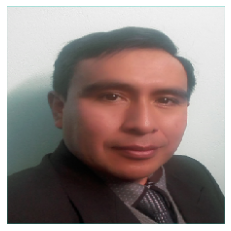

In [23]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array

#image_path = './data/validacion/Adm  Edith Linn Colque Apaza - Secretaria/UNAMBA_ E_51.jpeg'#Ojo con Lena da 8,UNAMBA_18550.jpeg
image_path = './data05/prueba_final/erech.png'#Ojo con Lena da 8,UNAMBA_18550.jpeg

longitud, altura =224,224 #110 ,110            #UNAMBA_203466 , UNAMBA_212405, UNAMBA_218849, UNAMBA_315888, UNAMBA_84674 con mod 06 no funci
imagen=load_img(image_path, target_size=(longitud, altura),color_mode="rgb") #"grayscale"   
#x.show() #Imprime el numero en una ventana

plt.imshow(imagen, cmap='gray_r')
plt.axis('off')

imagen=img_to_array(imagen)
imagen=np.expand_dims(imagen,axis=0)
imagen /= 255.


arreglo= modelo.predict(imagen)#PREDICCION

prediccion_array=list(arreglo[0])
suma=0
for counter, value in enumerate(prediccion_array):
  prediccion_array[counter]=round(value,3)
  suma=suma+value

print("La suma de la prediccion es: ",suma)
print(prediccion_array)
print("Minimo: ",min(prediccion_array))
print("Máximo: ",max(prediccion_array))

n01,n02 = predicciones_nombres(prediccion_array,target_names_reducido,valor_minimo=0.001) #estaba 0.3

print('Etiquetas: ',target_names_reducido)

print("Primera prediccion: ",n01[0], " al ",n01[1]*100,"%")
print("Segunda Prediccion: ",n02[0], " al ",n02[1]*100,"%")

<h1> Cargar el modelo y predecir
</h1>


In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%cd /content/drive/My Drive/ColabNotebooks
#%ls
%pwd

In [0]:
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
import matplotlib.pyplot as plt
import keras
import csv
import pickle

In [0]:
modelo_recup = load_model('./modelo0/modelo.h5')
modelo_recup.load_weights('./modelo0/pesos.h5')

labels_recup=list()
archivo = open("./modelo0/labels.txt", "r") 
for linea in archivo.readlines():
  labels_recup.append(linea[:-1]) 
archivo.close()

with open('./modelo0/mod_compi_history.txt', 'rb') as f:  
  modeloEntrenado_history = pickle.load(f)


In [0]:
#modelo_recup.summary()

In [0]:
from keras import backend as k
np.random.seed(2)
ruta_data_validacion = './data/validacion'
longitud, altura = 224,224  #160, 160 #96,96 #128,128

In [0]:
def nombre_corto (nombres):
    nombres_cortos=list()
    for nombre in nombres:
        cad=""
        vacio=0
        for i in nombre[4:]:
            if(i!="_" or i!=" " and vacio<=2):
                
                cad=cad+i
                if(vacio==2):
                    cad=cad+"."
                    break
            if(i=="_" or i==" "):
                vacio=vacio+1

                
        nombres_cortos.append(cad)
    return nombres_cortos

In [0]:
def predicciones_nombres(lista_predicciones,lista_etiquetas,valor_minimo=0.3):
    nombre_01="No identificado"
    nombre_02="No identificado"
    da01=0.0
    da02=0.0
    for i,data in enumerate(lista_predicciones):
        if(data>=valor_minimo):
            if(data>=da01):#intercambio de variables
                aux01=da01
                da01=data
                aux02=nombre_01
                nombre_01=lista_etiquetas[i] 
                da02=aux01
                nombre_02=aux02
    return (nombre_01,da01),(nombre_02,da02)

Consultas individuales

[1.3259944e-09, 1.641016e-11, 1.4149182e-07, 5.913783e-07, 2.6731941e-08, 3.386275e-07, 8.869837e-07, 2.1797573e-06, 3.8723883e-07, 5.033551e-06, 4.0321723e-07, 5.242037e-10, 4.6998574e-09, 1.7716554e-06, 7.280271e-06, 1.6147644e-07, 1.5586336e-07, 8.354888e-07, 1.3057905e-07, 4.0668987e-05, 2.612697e-10, 4.6007788e-08, 5.079383e-09, 1.9491702e-08, 8.232835e-09, 5.440721e-07, 1.0682564e-07, 3.5820498e-09, 4.7636365e-07, 7.796283e-09, 0.01673069, 0.003121181, 4.0925993e-06, 6.4506975e-07, 1.7394806e-08, 0.00018692862, 0.0005524638, 2.8709833e-08, 3.7470453e-09, 5.294873e-10, 8.4612924e-07, 7.841011e-06, 1.984615e-07, 4.540035e-09, 3.0531149e-09, 8.8843635e-09, 1.1564101e-08, 7.3924884e-09, 2.5827806e-06, 4.8952318e-09, 5.5626415e-09, 3.5639053e-07, 9.48169e-08, 1.0081234e-08, 3.5833366e-06, 5.79159e-07, 1.0833046e-09, 3.185013e-08, 1.4906936e-09, 4.146421e-10, 2.7271326e-06, 1.7827931e-07, 1.7775339e-07, 6.349753e-06, 0.0010366227, 3.6150007e-06, 0.85157186, 7.153658e-07, 4.7677613e-06,

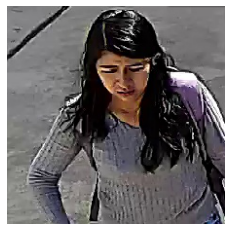

In [30]:

import matplotlib.pyplot as plt

image_path = './modelo0/Falsos/UNAMBA_100687.jpeg'#Ojo con Lena, IMG_20181225_151628.jpg
imagen=load_img(image_path, target_size=(longitud, altura),color_mode="rgb") #"grayscale"   
#x.show() #Imprime el numero en una ventana

plt.imshow(imagen, cmap='gray_r')
plt.axis('off')

imagen=img_to_array(imagen)
imagen=np.expand_dims(imagen,axis=0)
imagen /= 255.

arreglo= modelo_recup.predict(imagen)#PREDICCION
prediccion_array=list(arreglo[0])

print(prediccion_array)
print("Minimo: ",min(prediccion_array))
print("Máximo: ",max(prediccion_array))
n01,n02 = predicciones_nombres(prediccion_array,labels_recup,valor_minimo=0.02)

print('Etiquetas: ',labels_recup)

print("Primera prediccion: ",n01[0], " al ",n01[1]*100,"%")
print("Segunda Prediccion: ",n02[0], " al ",n02[1]*100,"%")

Consulta a todo un directorio

In [31]:
import os
import os.path
direccion='./modelo0/Falsos/'
listaArchivos=os.listdir(direccion)
#print(listaArchivos)
falsos_positivos=0
menor=100
for i, item in enumerate(listaArchivos):
  ruta=direccion+'/'+item
  imagen=load_img(ruta, target_size=(longitud, altura),color_mode="rgb")    
  imagen=img_to_array(imagen)
  imagen=np.expand_dims(imagen,axis=0)
  imagen /= 255.
  arreglo= modelo_recup.predict(imagen)#PREDICCION
  prediccion_array=list(arreglo[0])
  n01,n02 = predicciones_nombres(prediccion_array,labels_recup,valor_minimo=0.15)
  print(item)
  print("Primera prediccion: ",n01[0], " al ",n01[1]*100,"%")
  print("Segunda Prediccion: ",n02[0], " al ",n02[1]*100,"%")
  print(i," ======================")
  if n01[1] < 0.15 :
    falsos_positivos = falsos_positivos +1
  if n01[1] < menor:
      menor=n01[1]
print("Falsos positivos: ",falsos_positivos, "de: ",len(listaArchivos))
print("El menor valor de todos: ",menor*100," %")

UNAMBA_50972.jpeg
Primera prediccion:  Adm_Rofwel_Quisca_Quispe_Medico  al  66.26827120780945 %
Segunda Prediccion:  No identificado  al  0.0 %
0  ======================
UNAMBA_147579.jpeg
Primera prediccion:  Adm_Jesus_Santos_Huarniz_Farfan  al  62.235027551651 %
Segunda Prediccion:  No identificado  al  0.0 %
1  ======================
UNAMBA_316929.jpeg
Primera prediccion:  Adm_Betina_Lourdes_Valderrama_Cardenas___Enfermera  al  74.72116351127625 %
Segunda Prediccion:  No identificado  al  0.0 %
2  ======================
UNAMBA_31820.jpeg
Primera prediccion:  Doc_Wilson_Mollocondo_Flores__Ciencias_Básicas  al  40.46018123626709 %
Segunda Prediccion:  Doc_Edison_Chiclla_Cari__Agro  al  30.893176794052124 %
3  ======================
UNAMBA_204311.jpeg
Primera prediccion:  Adm_Nilo_Farfan_Mendoza  al  43.41439604759216 %
Segunda Prediccion:  Adm_Miluska_Vila_Baes__Secretaria  al  25.940337777137756 %
4  ======================
UNAMBA_1031.jpeg
Primera prediccion:  Adm_Sumilda_Bengolea_D

In [0]:
import tensorflow as tf
import os
#os.cpu_count() #numero de cpu en el sist operativo

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#device_lib.list_local_devices()




<h1>Procesamiento de datos y gráficas </h1>

---



In [0]:
epocas_ =14  #epocas entrenadas
plt.figure(0)
plt.plot(modeloEntrenado_history['acc'],'r')
plt.plot(modeloEntrenado_history['val_acc'],'g')
plt.xticks(np.arange(0, epocas_, 1.0)) #numero de epocas
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])

plt.figure(1)
plt.plot(modeloEntrenado_history['loss'],'r')
plt.plot(modeloEntrenado_history['val_loss'],'g')
plt.xticks(np.arange(0, epocas_, 1.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])

plt.figure(2)
plt.plot(modeloEntrenado_history['mean_squared_error'],'r')
plt.plot(modeloEntrenado_history['val_mean_squared_error'],'g')
plt.xticks(np.arange(0, epocas_, 1.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("MSE")
plt.title("Mean Squared Error vs Validation Mean Squared Error")
plt.legend(['train','validation'])
 
plt.show()

In [0]:
from keras.preprocessing.image import ImageDataGenerator
validacion_datagen = ImageDataGenerator(rescale = 1. / 255)

validacion_generador = validacion_datagen.flow_from_directory(
    ruta_data_validacion,     #ruta de la carpeta de imagenes validacion
    target_size=(altura, longitud),
    color_mode='rgb',#'grayscale'
    batch_size=1,#batch_size,
    class_mode='categorical',  #None, para devolver solo las imágenes
    shuffle = False,           #se requiere mostrar en orden las imagenes de salida
    seed = 42) 

In [0]:
pred = modelo_recup.predict_generator(validacion_generador, steps=None, max_queue_size=10, workers=200, use_multiprocessing=True, verbose=1)
predicted = np.argmax(pred, axis=1)

In [0]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

x=validacion_generador.classes                         
cm = confusion_matrix(x, predicted)
accurancy=accuracy_score(x,predicted)
recall=recall_score(x, predicted, average='macro')
print("Accurancy: ",accurancy)
print("Recall: ",recall)


In [0]:
nclases=242
nombre_clases = nombre_corto(labels_recup)
df_cm = pd.DataFrame(cm,nombre_clases, nombre_clases) 
plt.figure(figsize = (60,60))  #tamaño de la imagen longitud y altura
sn.set(font_scale=0.8) # tamaño de las clases
#df_cm.to_csv('matrizConfusion.csv')# guardar la matriz de conf
grafica=sn.heatmap(df_cm,cmap='coolwarm',annot=True, annot_kws={"size": 9},cbar=False)
grafica.set(xlabel='Predicciones',ylabel='Datos Originales')
plt.show()


In [0]:
#guardar la matriz de confusion
df_cm.to_csv('./modelo0/matrizConfusion.csv')# guardar la matriz de conf

In [0]:
import pickle
import numpy as np 
import csv
reporte_clasif=classification_report(validacion_generador.classes, predicted, target_names=nombre_clases,output_dict=True)
#reporte = pd.DataFrame(reporte_clasif,range(242),range(1))#,columns=['Names', 'Precision', 'Recall','F1-Score','Suport']) 
print(reporte_clasif)


In [0]:
import pandas as pd
dataform=pd.DataFrame.from_dict(data=reporte_clasif).transpose()
dataform.to_csv('./modelo0/reporteF.csv', header=reporte_clasif.keys()) 

In [0]:
evaluacionDelModelo=modelo_recup.evaluate_generator(validacion_generador, steps=None, max_queue_size=10, workers=100, use_multiprocessing=True)
print(evaluacionDelModelo)#Loss, Acc, Mean_scuared_error # demora mucho tiempo casi igual al entrenamiento 

In [0]:
print(prediccion_array)
print(etiquetas)
print(labels_recup)

In [0]:
print(validacion_generador.num_classes)

In [0]:
from keras.applications import  vgg16 #densenet, resnet50,
model = vgg16.VGG16(include_top=True, weights=None, input_tensor=None, input_shape=(48,48,3), pooling=None, classes=100)

In [0]:
#model.summary()

<h1>Comparar todos los entrenamientos</h1> 

In [0]:
import matplotlib.pyplot as plt

import pickle
with open('./modelo0/mod_compi_history.txt', 'rb') as f:  
  vgg16_history = pickle.load(f)

with open('./modelo0fVGG16UNAMBA/mod_compi_history.txt', 'rb') as f:  
  vgg16_Unamba_history = pickle.load(f)

with open('./modeloDenseNetUNAMBA/mod_compi_history.txt', 'rb') as f:  
  DenseNet_Unamba_history = pickle.load(f)

with open('./modelo11/mod_compi_history.txt', 'rb') as f:  
  DenseNet121_history = pickle.load(f)

In [0]:
import numpy as np 
plt.figure(0)
plt.plot(vgg16_history['val_acc'],'r')
plt.plot(vgg16_Unamba_history['val_acc'],'b') 
plt.plot(DenseNet121_history['val_acc'],'y')   
plt.plot(DenseNet_Unamba_history['val_acc'],'g')  

plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("VGG16 Accuracy vs DenseNetUNAMBA Accuracy")  
plt.legend(['VGG16','VGG16UNAMBA','DenseNet121','DenseNet121UNAMBA'])  